In [1]:
import numpy as np # linear algebra
import pandas as pd 

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', usecols = ['Review Text', 'Recommended IND'])
data.columns = ['review', 'sentiment']
# remove nan
data.dropna(inplace = True)
print(data.shape)
data.head()

(22641, 2)


,review,sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [16]:
data = data[data.review != '']
data.shape

(22641, 2)

In [3]:
data['sentiment'].value_counts() / data.shape[0]

1    0.818868
0    0.181132
Name: sentiment, dtype: float64

## Prepare testing data from MongoDB

In [4]:
from pymongo import MongoClient
import pandas as pd
from bson.objectid import ObjectId

client = MongoClient()
db = client.seasalt
collection = db.shopee

test = collection.find({"$and": [{"product_breadcrumb": "Women's Apparel"}, {"product_review":{"$ne":[] }}]}, {"product_name": 1, "product_breadcrumb": 1, "product_id": 1, "product_review": 1})
data2 = []
for x in test:
    data2.append(x)
len(data2)

6696

In [9]:
# top 10 products

ll = [len(x['product_review']) for x in data]
idx = sorted(range(len(ll)), reverse = True, key=ll.__getitem__)[:10]
print(idx)
amt = sorted(ll, reverse = True)[:10]
print(amt)
prd = [data2[x]['product_name'] for x in idx]
# print(prd)
for i in range(len(prd)):
    print(i+1, " ", prd[i], "")

[2188, 2194, 2128, 2101, 5566, 2147, 5484, 4585, 2109, 4551]
[2078, 694, 689, 594, 529, 462, 295, 256, 237, 196]
1   READY STOCK ！ oversized tee basic t-shirts koreanfashion simple white blouse 
2   Ready STOCK！hot sale loose short sleeves show slim summer girl 
3   [READY STOCK] (Best Seller!!) JYUNEESG'S Loose fit Basic High Neck TOP 
4   7 color optional Ready Stock！Retro Loose Speaker Sleeve Round Long Sleeve TShirt 
5   ⭐️BUY 4 FREE 1⭐️MUNAFIE SEAMLESS SLIMMING PANTIES⭐️ 
6   White shirt female long sleeve han fan wide loose south Korean shirt 
7   Silicone Nipple Cover Sticker Pads Shields Guard for Gown 
8   MONTIFS Strap Culottes - Multi Color 
9   [READY STOK] BL-B-06 Knitted Turtle Neck T-Shirt Top 
10   ✨HOT Women Warm Winter Thick Footless Tights Skinny Slim Leggings Stretch Pants 


In [10]:
rev = []
dts = []
for i in data2[2101]["product_review"]:
    rev.append(i['buyer_review'])
    dts.append(i['review_date'].split(" ")[0])

print(len(rev))

dff = pd.DataFrame({
    'review': rev,
    'date': dts
})
dff['sentiment'] = 0
dff = dff[dff['review'] != '']
dff.head()

594


,date,review,sentiment
2,2018-05-26,Good product quality Fast delivery Fast delive...,0
3,2018-05-26,Good product quality Excellent service by seller,0
4,2018-05-25,Good product quality Fast delivery,0
5,2018-05-25,Fast delivery Good product quality Excellent s...,0
6,2018-05-25,Good product quality Fast delivery Excellent s...,0


In [11]:
dff.shape

(299, 3)

## Validation data from Lazada

In [3]:
df = pd.read_csv("lazada_labelled.csv")
df2 = df[["review", "sentiment"]]
df2.head()

,review,sentiment
0,Received item really fast. item was genuine an...,1
1,Super fast delivery and item looks exactly lik...,1
2,A bit picky...need to wear inner layer before ...,0
3,Definitely will recommend to others,1
4,Material is good recommended,1


In [13]:
df2.shape

(334, 2)

### Combine train and test

In [6]:
# df3 = dff[['review', 'sentiment']]
n1 = data.shape[0]
n2 = df2.shape[0]
# n3 = df3.shape[0]
# data = data.append(df3, ignore_index = True)
# dfa = pd.concat([data, df2, df3], ignore_index=True)
dfa = pd.concat([data, df2], ignore_index=True)
print(n1, n2)
print(dfa.shape)

22641 334
(22975, 2)


In [76]:
df3.head()

,review,sentiment
2,Good product quality Fast delivery Fast delive...,0
3,Good product quality Excellent service by seller,0
4,Good product quality Fast delivery,0
5,Fast delivery Good product quality Excellent s...,0
6,Good product quality Fast delivery Excellent s...,0


## Preprocess

In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/qy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    # other
    text = re.sub(r'[^a-zA-Z]',' ',text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

In [10]:
data.review[:5].tolist()

['Absolutely wonderful - silky and sexy and comfortable',
 'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments

In [9]:
max_fatures = 2000
mlen = 100

tokenizer = Tokenizer(num_words=max_fatures, lower=True,split=' ')
tokenizer.fit_on_texts(dfa['review'].values)
X = tokenizer.texts_to_sequences(dfa['review'].values)
X = pad_sequences(X, maxlen=mlen)
Y = pd.get_dummies(dfa['sentiment']).values

X_train, X_valid, Y_train, Y_valid = train_test_split(X[:n1],Y[:n1], test_size = 0.30, random_state = 36)
print(X_train.shape)
print(X_valid.shape)

(15848, 100)
(6793, 100)


In [28]:
print(X.shape)
print(Y.shape)
print(X[n1:].shape)

(23274, 100)
(23274, 2)
(633, 100)


In [79]:
df3.head()

,review,sentiment
2,Good product quality Fast delivery Fast delive...,0
3,Good product quality Excellent service by seller,0
4,Good product quality Fast delivery,0
5,Fast delivery Good product quality Excellent s...,0
6,Good product quality Fast delivery Excellent s...,0


In [25]:
data['sentiment'].value_counts()

1    18540
0     4101
Name: sentiment, dtype: int64

## Simple LSTM model

In [32]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout

embed_dim = 100
batch_size = 32

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model.add(Dropout(0.2))
# model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(LSTM(128,dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 617,506
Trainable params: 617,506
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-lstm.h5', verbose=1, save_best_only=True)

model.fit(X_train, Y_train, validation_split=0.3, batch_size=batch_size, epochs=10, verbose = 2, 
                    callbacks=[earlystopper])

Train on 11093 samples, validate on 4755 samples
Epoch 1/10
 - 46s - loss: 0.3631 - acc: 0.8439 - val_loss: 0.2884 - val_acc: 0.8757
Epoch 2/10
 - 47s - loss: 0.2642 - acc: 0.8882 - val_loss: 0.2800 - val_acc: 0.8839
Epoch 3/10
 - 47s - loss: 0.2226 - acc: 0.9056 - val_loss: 0.2808 - val_acc: 0.8869
Epoch 4/10
 - 46s - loss: 0.2028 - acc: 0.9167 - val_loss: 0.2975 - val_acc: 0.8902
Epoch 5/10
 - 48s - loss: 0.1809 - acc: 0.9279 - val_loss: 0.3210 - val_acc: 0.8797
Epoch 00005: early stopping


In [36]:
# loss, [sen, spec, acc] = model.evaluate(X_valid, Y_valid, verbose = 2, batch_size = batch_size)
loss, acc = model.evaluate(X_valid, Y_valid, verbose = 2, batch_size = batch_size)
print("score: %.3f" % (loss))
print("acc: %.3f" % (acc))

score: 0.308
acc: 0.880


## Model with Conv1D + 2 LSTM layers

In [10]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout

embed_dim = 200
batch_size = 16

model_conv3 = Sequential()
model_conv3.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model_conv3.add(Dropout(0.2))
model_conv3.add(Conv1D(64, 5, activation='relu'))
model_conv3.add(MaxPooling1D(pool_size=4))
model_conv3.add(LSTM(128,dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model_conv3.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5))
model_conv3.add(Dense(2, activation='softmax'))
model_conv3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_conv3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          400000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            64064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total para

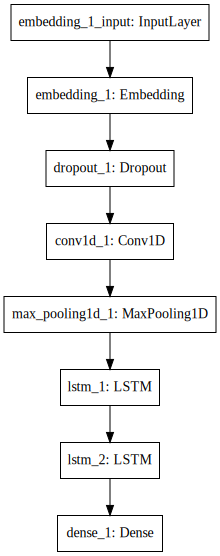

In [11]:
import pydot
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model_conv3, to_file='sentiment_lstm.png')
SVG(model_to_dot(model_conv3).create(prog='dot', format='svg'))

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('lstm_f.h5', verbose=1, save_best_only=True)

model_conv3.fit(X_train, Y_train, validation_split=0.3, batch_size=batch_size, epochs=10, verbose = 2, 
                    callbacks=[earlystopper, checkpointer])

loss, acc = model_conv3.evaluate(X_valid, Y_valid, verbose = 2, batch_size = batch_size)
print("score: %.3f" % (loss))
print("acc: %.3f" % (acc))

Train on 11093 samples, validate on 4755 samples
Epoch 1/10
Epoch 00001: val_loss improved from inf to 0.28086, saving model to lstm_f.h5
 - 52s - loss: 0.3591 - acc: 0.8459 - val_loss: 0.2809 - val_acc: 0.8860
Epoch 2/10
Epoch 00002: val_loss improved from 0.28086 to 0.27641, saving model to lstm_f.h5
 - 50s - loss: 0.2455 - acc: 0.8980 - val_loss: 0.2764 - val_acc: 0.8862
Epoch 3/10
Epoch 00003: val_loss did not improve
 - 50s - loss: 0.1958 - acc: 0.9195 - val_loss: 0.2892 - val_acc: 0.8841
Epoch 4/10
Epoch 00004: val_loss did not improve
 - 51s - loss: 0.1454 - acc: 0.9435 - val_loss: 0.3511 - val_acc: 0.8845
Epoch 5/10
Epoch 00005: val_loss did not improve
 - 50s - loss: 0.1024 - acc: 0.9626 - val_loss: 0.3951 - val_acc: 0.8675
Epoch 00005: early stopping
score: 0.388
acc: 0.868


In [62]:
from keras.models import load_model

model3 = load_model('lstm_f.h5')

loss, acc = model3.evaluate(X_valid, Y_valid, verbose = 2, batch_size = batch_size)
print("score: %.3f" % (loss))
print("acc: %.3f" % (acc))

score: 0.255
acc: 0.885


In [63]:
loss, acc = model2.evaluate(X[n1:(n1+n2)], Y[n1:(n1+n2)], verbose = 2, batch_size = batch_size)
print("score: %.3f" % (loss))
print("acc: %.3f" % (acc))

score: 0.443
acc: 0.766


In [65]:
loss, acc = model_conv3.evaluate(X[n1:(n1+n2)], Y[n1:(n1+n2)], verbose = 2, batch_size = batch_size)
print("score: %.3f" % (loss))
print("acc: %.3f" % (acc))

score: 0.480
acc: 0.811


## Predict target labels

In [ ]:
pred = model.predict(X[n1:(n1+n2)], batch_size=1,verbose = 2)

In [ ]:
y_pred = np.argmax(pred,axis=1)
y_pred[:10]

## Performance on the Validation set

In [38]:
pred = model.predict(X[n1:(n1+n2)], batch_size=1,verbose = 2)

In [69]:
# conv + lstm model
pred2 = model_conv3.predict(X[n1:(n1+n2)], batch_size=1,verbose = 2)
y_pred_proba = pred2[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)

0.750431034483


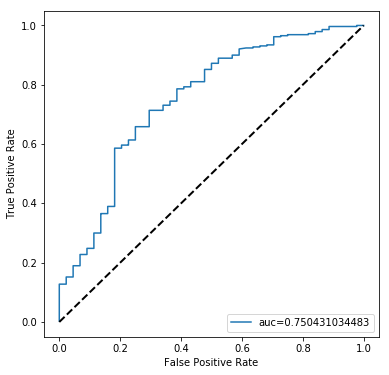

In [67]:
y_pred_proba = pred2[:, 1]
y_test = df2['sentiment'].values

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## Predict on new data

In [40]:
pred = model.predict(X[(n1+n2):], batch_size=1,verbose = 2)
pred[:5]

array([[ 0.00400818,  0.99599189],
       [ 0.01446713,  0.98553282],
       [ 0.23878399,  0.76121598],
       [ 0.00721742,  0.99278259],
       [ 0.0021237 ,  0.99787629]], dtype=float32)

In [41]:
dff['sentiment'] = list(pred[:, 1])
dff.head()

,date,review,sentiment
2,2018-05-26,Good product quality Fast delivery Fast delive...,0.995992
3,2018-05-26,Good product quality Excellent service by seller,0.985533
4,2018-05-25,Good product quality Fast delivery,0.761216
5,2018-05-25,Fast delivery Good product quality Excellent s...,0.992783
6,2018-05-25,Good product quality Fast delivery Excellent s...,0.997876


In [42]:
df_out = dff.copy()
df_out['month'] = pd.to_datetime(df_out['date']).dt.month
df_out['year'] = pd.to_datetime(df_out['date']).dt.year
df_out['year_month'] = df_out['year'].astype(str) + '-' + df_out['month'].astype(str)

df_out.head(3)

,date,review,sentiment,month,year,year_month
2,2018-05-26,Good product quality Fast delivery Fast delive...,0.995992,5,2018,2018-5
3,2018-05-26,Good product quality Excellent service by seller,0.985533,5,2018,2018-5
4,2018-05-25,Good product quality Fast delivery,0.761216,5,2018,2018-5


In [43]:
## group by date

out = df_out[['year_month', 'sentiment']].groupby(['year_month']).mean()
out

,sentiment
year_month,
2017-10,0.783685
2017-11,0.662675
2017-12,0.652149
2018-1,0.696163
2018-2,0.741647
2018-3,0.617312
2018-4,0.714792
2018-5,0.595237


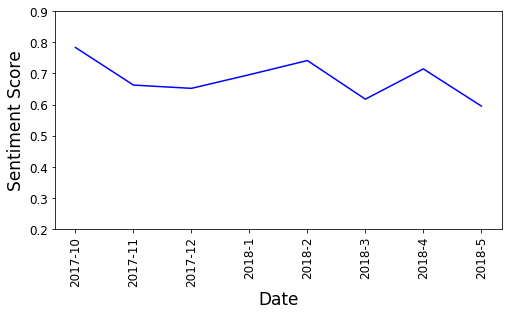

In [57]:
import matplotlib.pyplot as plt

year = list(out.index)
pop = list(out.sentiment)

plt.figure(figsize=(8,4))
plt.plot(year, pop, color='b')
plt.xlabel('Date', size = 17)
plt.ylabel('Sentiment Score', size = 17)
# plt.title('Women Clothing review sentiment', size = 20)
plt.xticks(rotation=90, size = 12)
plt.yticks(size = 12)
plt.ylim(ymin=0.2, ymax = 0.9)
plt.show()

## References
Dealing with Unbalanced Classes in Machine Learning    
http://www.deepideas.net/unbalanced-classes-machine-learning/  

https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47

for binary_crossentropy: sigmoid activation, scalar target    
for categorical_crossentropy: softmax activation, one-hot encoded target   
https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance  

svm code sample:   
https://gist.github.com/bonzanini/c9248a239bbab0e0d42e

https://www.kaggle.com/nafisur/keras-lstm

Text Classification Using CNN, LSTM and visualize Word Embeddings: Part1-4    
https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b